# **Imports**

In [ ]:
#Imports
import tensorflow as tf
tf.__version__

import os
import pathlib
import time
import datetime
import scipy.io
import glob
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from IPython import display

#Check if it runs on GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# **Load data**

In [ ]:
#Import Google Drive to load the WGAN dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Diplomityo/Dataset_WGAN/

mean300.mat  test_mats	   test.txt	  train.txt
test_images  test_set.zip  train_set.zip


In [ ]:
#remove existing dir, if any
!rm -rf /content/Dataset_WGAN

#Make a new dir
!mkdir /content/Dataset_WGAN

#load and (quietly) extract the train files from Drive
!unzip -q /content/drive/MyDrive/Diplomityo/Dataset_WGAN/train_set.zip -d /content/Dataset_WGAN/

!ls /content/Dataset_WGAN/

train_images  train_mats


# Test that reading .mat files works

In [ ]:
dir_img = "/content/Dataset_WGAN/train_images"
dir_mat = "/content/Dataset_WGAN/train_mats"

mat1 = scipy.io.loadmat(dir_mat + "/cloudy_mask_0001.mat")

print(mat1)

mat2 = mat1["seg_mask"]

print(type(mat1))
print(type(mat2))
print(mat2.shape)
print(mat2[0][0])

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun 15 15:21:45 2017', '__version__': '1.0', '__globals__': [], 'seg_mask': array([[4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 5, 5, 5],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}
<class 'dict'>
<class 'numpy.ndarray'>
(300, 300)
4


# Generator architectures G0, G1, G2, G3

# G0: Test generator with noise input

In [ ]:
def make_densed_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512, input_shape=(100,)))

    model.add(layers.Reshape((4, 4, 512)))
    model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=4, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False))
    #assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False))
    #assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False))
    #assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2D(3, kernel_size=4, strides=2, padding="same", activation="tanh"))
    print(model.output_shape)
    assert model.output_shape == (None, 64, 64, 3)

    return model    

G1: Initial Transformation model 

G2: Attention model

G3: Weather-cue segmentation model

# Discriminator Architecture

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, 4, strides=2, padding='same',
                                     input_shape=[IMAGE_DIM, IMAGE_DIM, CHANNELS])) #As of now, this input only considers G0/G1. Eventually, it will also need to include G2 and G3
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(512, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

# Initialize variables and preprocess the data

Found 8000 files belonging to 1 classes.


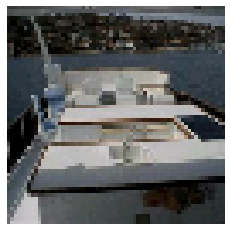

In [ ]:
#Defining variables
dir_img = "/content/Dataset_WGAN/train_images"
dir_mat = "/content/Dataset_WGAN/train_mats"
BATCH_SIZE = 16
EPOCHS = 500
NOISE_DIM = 100
IMAGE_DIM_ORIGINAL = 300
IMAGE_DIM = 64 # I'm using resolution 64*64*3 for testing, instead of the original 300*300*3
CHANNELS = 3
num_examples_to_generate = 9


# Load the images to dataset, must sometimes be inside a /train directory in the target directory
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
dataset = keras.preprocessing.image_dataset_from_directory(
    dir_img, label_mode=None, image_size=(IMAGE_DIM, IMAGE_DIM), color_mode="rgb", batch_size=BATCH_SIZE, shuffle=True
)

# Normalize the dataset to range [-1, 1]
dataset = dataset.map(lambda x: (x / 127.5) - 1)

# Show a sample image
for x in dataset:
    plt.axis("off")
    plt.imshow(((x.numpy() + 1) * 127.5).astype("int32")[0])
    break

"""def generator_preprocess(img):
    img = img.astype(np.float32)
    img = img / 127.5 - 1
    return img

img_gen = ImageDataGenerator(
    generator_preprocess=prep_fn
)

train_gen = img_gen.flow_from_directory(dir_img, target_size=(IMAGE_DIM, IMAGE_DIM), color_mode="rgb", batch_size=BATCH_SIZE, classes=None, class_mode=None, shuffle=True)
"""

#seed for results
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      pred = (predictions[i,:,:,:] + 1) * 127.5   
      pred = pred.numpy()
      fig.add_subplot(3, 3, i+1)
      img = keras.preprocessing.image.array_to_img(pred)    
      plt.imshow((img))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

(None, 64, 64, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 512)      4194304   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 512)      2048      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 3

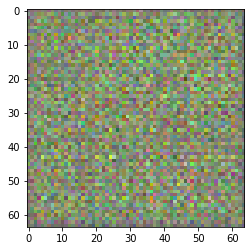

In [ ]:
# Test that the generator runs without error with the new configuration, and initialize it
generator = make_densed_generator_model()

#noise = tf.random.normal([1,1,1,100]) #Noise for Conv2D Generator input
noise = tf.random.normal([1,100]) #Noise for Dense Generator input
generated_image = generator(noise, training=False)

#Check that the normalization works by normalizing and then de-normalizing before viewing the image
gene = (generated_image[:,:,:] - 1) / 127.5
gene = (gene + 1) * 127.5
gene = gene.numpy()

img = keras.preprocessing.image.array_to_img(gene[0])
plt.imshow(img)

generator.summary()

In [ ]:
# Test that the discriminator runs without error with the new configuration, and initialize it
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
discriminator.summary()

tf.Tensor([[0.5000063]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 


In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Optimizers. Can try to change the beta1 and beta2 values
generator_optimizer = tf.keras.optimizers.Adam(5e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-4)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# For saving the model checkpoints
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/weather_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# To make the function compile
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    """with summary_writer.as_default():
      tf.summary.scalar('gen_total_loss', gen_loss, step=step//1000)
      tf.summary.scalar('disc_loss', disc_loss, step=step//1000)"""

# Main training loop
def train_custom(dataset, epochs):
  if len(os.listdir(checkpoint_dir) ) != 0:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print("Loaded model checkpoint!")
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Show images only every 15th epoch to decrease notebook size
    if (epoch + 1) % 15 == 0:
      generate_and_save_images(generator,
                              epoch + 1,
                              seed)
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    if (epoch + 1) % 60 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator,
                           epochs,
                           seed)

Time for epoch 1 is 47.036460638046265 sec
Time for epoch 2 is 81.9110198020935 sec
Time for epoch 3 is 45.38524913787842 sec
Time for epoch 4 is 44.80030298233032 sec
Time for epoch 5 is 45.1269314289093 sec
Time for epoch 6 is 45.02634024620056 sec
Time for epoch 7 is 45.17133641242981 sec
Time for epoch 8 is 45.090332984924316 sec
Time for epoch 9 is 45.143736839294434 sec
Time for epoch 10 is 45.110384702682495 sec
Time for epoch 11 is 45.004796743392944 sec
Time for epoch 12 is 45.12652659416199 sec
Time for epoch 13 is 45.018062114715576 sec
Time for epoch 14 is 81.91136384010315 sec


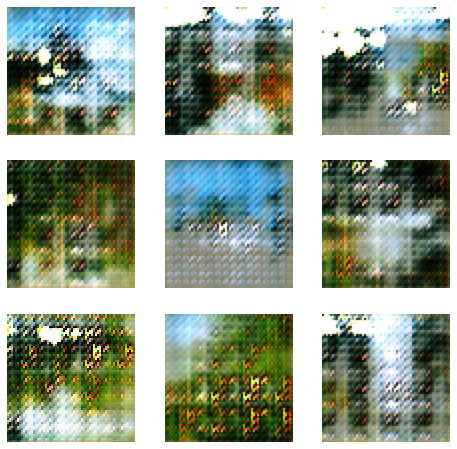

Time for epoch 15 is 46.64083647727966 sec
Time for epoch 16 is 44.77519726753235 sec
Time for epoch 17 is 45.18594026565552 sec
Time for epoch 18 is 45.00889182090759 sec
Time for epoch 19 is 45.02603244781494 sec
Time for epoch 20 is 44.98660159111023 sec
Time for epoch 21 is 44.881704568862915 sec
Time for epoch 22 is 44.887067794799805 sec
Time for epoch 23 is 81.91076827049255 sec
Time for epoch 24 is 45.38280963897705 sec
Time for epoch 25 is 44.77362895011902 sec
Time for epoch 26 is 45.01917767524719 sec
Time for epoch 27 is 44.86681604385376 sec
Time for epoch 28 is 44.99359178543091 sec
Time for epoch 29 is 45.01255393028259 sec


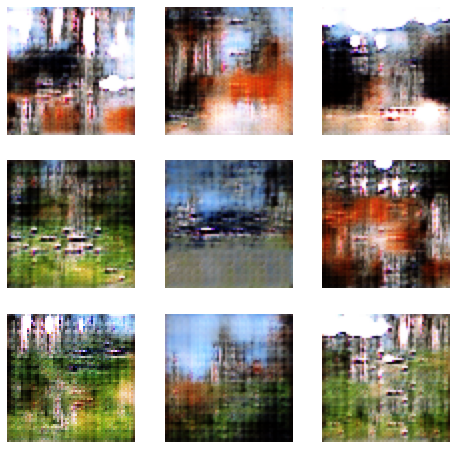

Time for epoch 30 is 46.16658163070679 sec
Time for epoch 31 is 44.98148775100708 sec
Time for epoch 32 is 44.931400775909424 sec
Time for epoch 33 is 81.91060590744019 sec
Time for epoch 34 is 45.415669679641724 sec
Time for epoch 35 is 44.808897972106934 sec
Time for epoch 36 is 45.03879523277283 sec
Time for epoch 37 is 44.89372706413269 sec
Time for epoch 38 is 45.0260055065155 sec
Time for epoch 39 is 81.91049313545227 sec
Time for epoch 40 is 45.317174434661865 sec
Time for epoch 41 is 44.793471813201904 sec
Time for epoch 42 is 45.13564133644104 sec
Time for epoch 43 is 44.998857498168945 sec
Time for epoch 44 is 45.09716749191284 sec


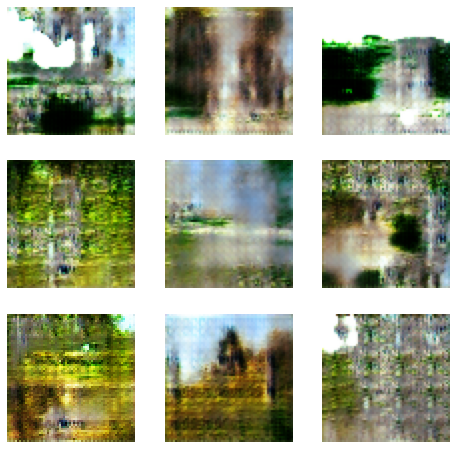

Time for epoch 45 is 46.16305160522461 sec
Time for epoch 46 is 45.17377591133118 sec
Time for epoch 47 is 45.17675757408142 sec
Time for epoch 48 is 44.99014115333557 sec
Time for epoch 49 is 44.92130470275879 sec
Time for epoch 50 is 44.927008628845215 sec
Time for epoch 51 is 45.00678992271423 sec
Time for epoch 52 is 45.08533549308777 sec
Time for epoch 53 is 45.04532170295715 sec
Time for epoch 54 is 45.07745432853699 sec
Time for epoch 55 is 44.85148024559021 sec
Time for epoch 56 is 81.91305708885193 sec
Time for epoch 57 is 45.44600033760071 sec
Time for epoch 58 is 44.92895221710205 sec
Time for epoch 59 is 45.26016330718994 sec


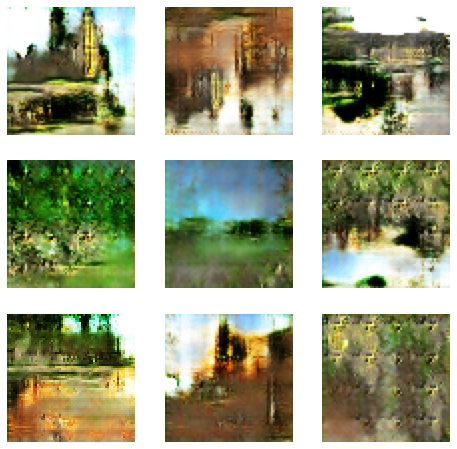

Time for epoch 60 is 46.64444375038147 sec
Time for epoch 61 is 45.17130255699158 sec
Time for epoch 62 is 45.104278326034546 sec
Time for epoch 63 is 45.048349142074585 sec
Time for epoch 64 is 81.91109848022461 sec
Time for epoch 65 is 45.39790058135986 sec
Time for epoch 66 is 44.905325412750244 sec
Time for epoch 67 is 44.99336099624634 sec
Time for epoch 68 is 81.91129469871521 sec
Time for epoch 69 is 45.20906925201416 sec
Time for epoch 70 is 44.621689319610596 sec
Time for epoch 71 is 44.98850607872009 sec
Time for epoch 72 is 44.81708097457886 sec
Time for epoch 73 is 44.90491032600403 sec
Time for epoch 74 is 44.8805468082428 sec


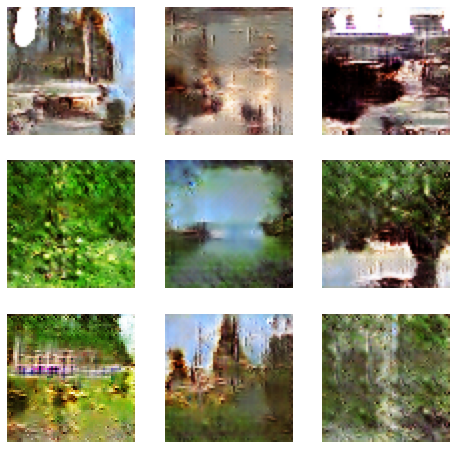

Time for epoch 75 is 46.39989447593689 sec
Time for epoch 76 is 44.91803550720215 sec
Time for epoch 77 is 44.9399573802948 sec
Time for epoch 78 is 44.94247770309448 sec
Time for epoch 79 is 44.842132568359375 sec
Time for epoch 80 is 44.86759424209595 sec
Time for epoch 81 is 44.85530209541321 sec
Time for epoch 82 is 44.896580934524536 sec
Time for epoch 83 is 44.86922907829285 sec
Time for epoch 84 is 44.87320017814636 sec
Time for epoch 85 is 44.83992671966553 sec
Time for epoch 86 is 44.816508054733276 sec
Time for epoch 87 is 44.82465744018555 sec
Time for epoch 88 is 44.891029357910156 sec
Time for epoch 89 is 44.973572969436646 sec


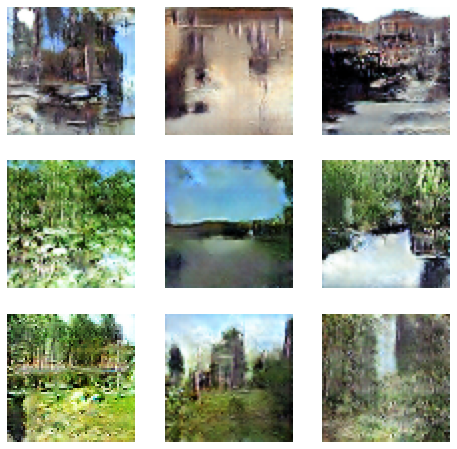

Time for epoch 90 is 46.13495182991028 sec
Time for epoch 91 is 44.90264058113098 sec
Time for epoch 92 is 44.88701558113098 sec
Time for epoch 93 is 44.896148443222046 sec
Time for epoch 94 is 45.04931592941284 sec
Time for epoch 95 is 45.051274061203 sec
Time for epoch 96 is 45.02160716056824 sec
Time for epoch 97 is 44.941418409347534 sec
Time for epoch 98 is 44.876951932907104 sec
Time for epoch 99 is 44.99150514602661 sec


In [ ]:
train_custom(dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
generated_image = generator(noise, training=True)

gene = (generated_image[:,:,:] - 1) / 127.5
gene = (gene + 1) * 127.5
gene = gene.numpy()

img = keras.preprocessing.image.array_to_img(gene[0])
plt.imshow(img)

def show_images(generator, num_images):
  noise = tf.random.normal([BATCH_SIZE, NOISE_DIMO])
  generated_image = generator(noise, training=True)
  fig = plt.figure(figsize=(8,8))

  for i in range(num_images):
      noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
      generated_image = generator(noise, training=True)  
      generated_image = generated_image.numpy()
      fig.add_subplot(3, 3, i+1)
      img = keras.preprocessing.image.array_to_img(pred)    
      plt.imshow((img))
      plt.axis('off')

  plt.show()